# TSA-HW2 (classic ML edition)

## Установка необходимых библиотек

In [ ]:
pip install numpy pandas tsfresh xgboost catboost lightgbm matplotlib seaborn

## Настройка внешнего вида графиков

In [2]:
import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("retina")
sns.set(style="whitegrid", font_scale=1.5)
sns.despine()

%matplotlib inline

<Figure size 640x480 with 0 Axes>

## Загрузка почасового датасета с данными о работе трансформаторов

In [3]:
data = pd.read_csv('ETTh1.csv')

In [4]:
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [5]:
data["date"] = pd.to_datetime(data["date"])

In [6]:
data_ticker = data[["date", "OT"]]

Для tsfresh создадим отдельную колонку "id", тождественно равную 0, чтобы библиотека понимала, что у нас только один временной ряд

In [7]:
data_ticker["id"] = 0

C:\Users\rusbe\AppData\Local\Temp\ipykernel_13592\348848496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ticker["id"] = 0


In [8]:
data_ticker.head()

,date,OT,id
0,2016-07-01 00:00:00,30.531000,0
1,2016-07-01 01:00:00,27.787001,0
2,2016-07-01 02:00:00,27.787001,0
3,2016-07-01 03:00:00,25.044001,0
4,2016-07-01 04:00:00,21.948000,0


Построим график для значения температуры масла в трансформаторе (OT)

<Axes: xlabel='date'>

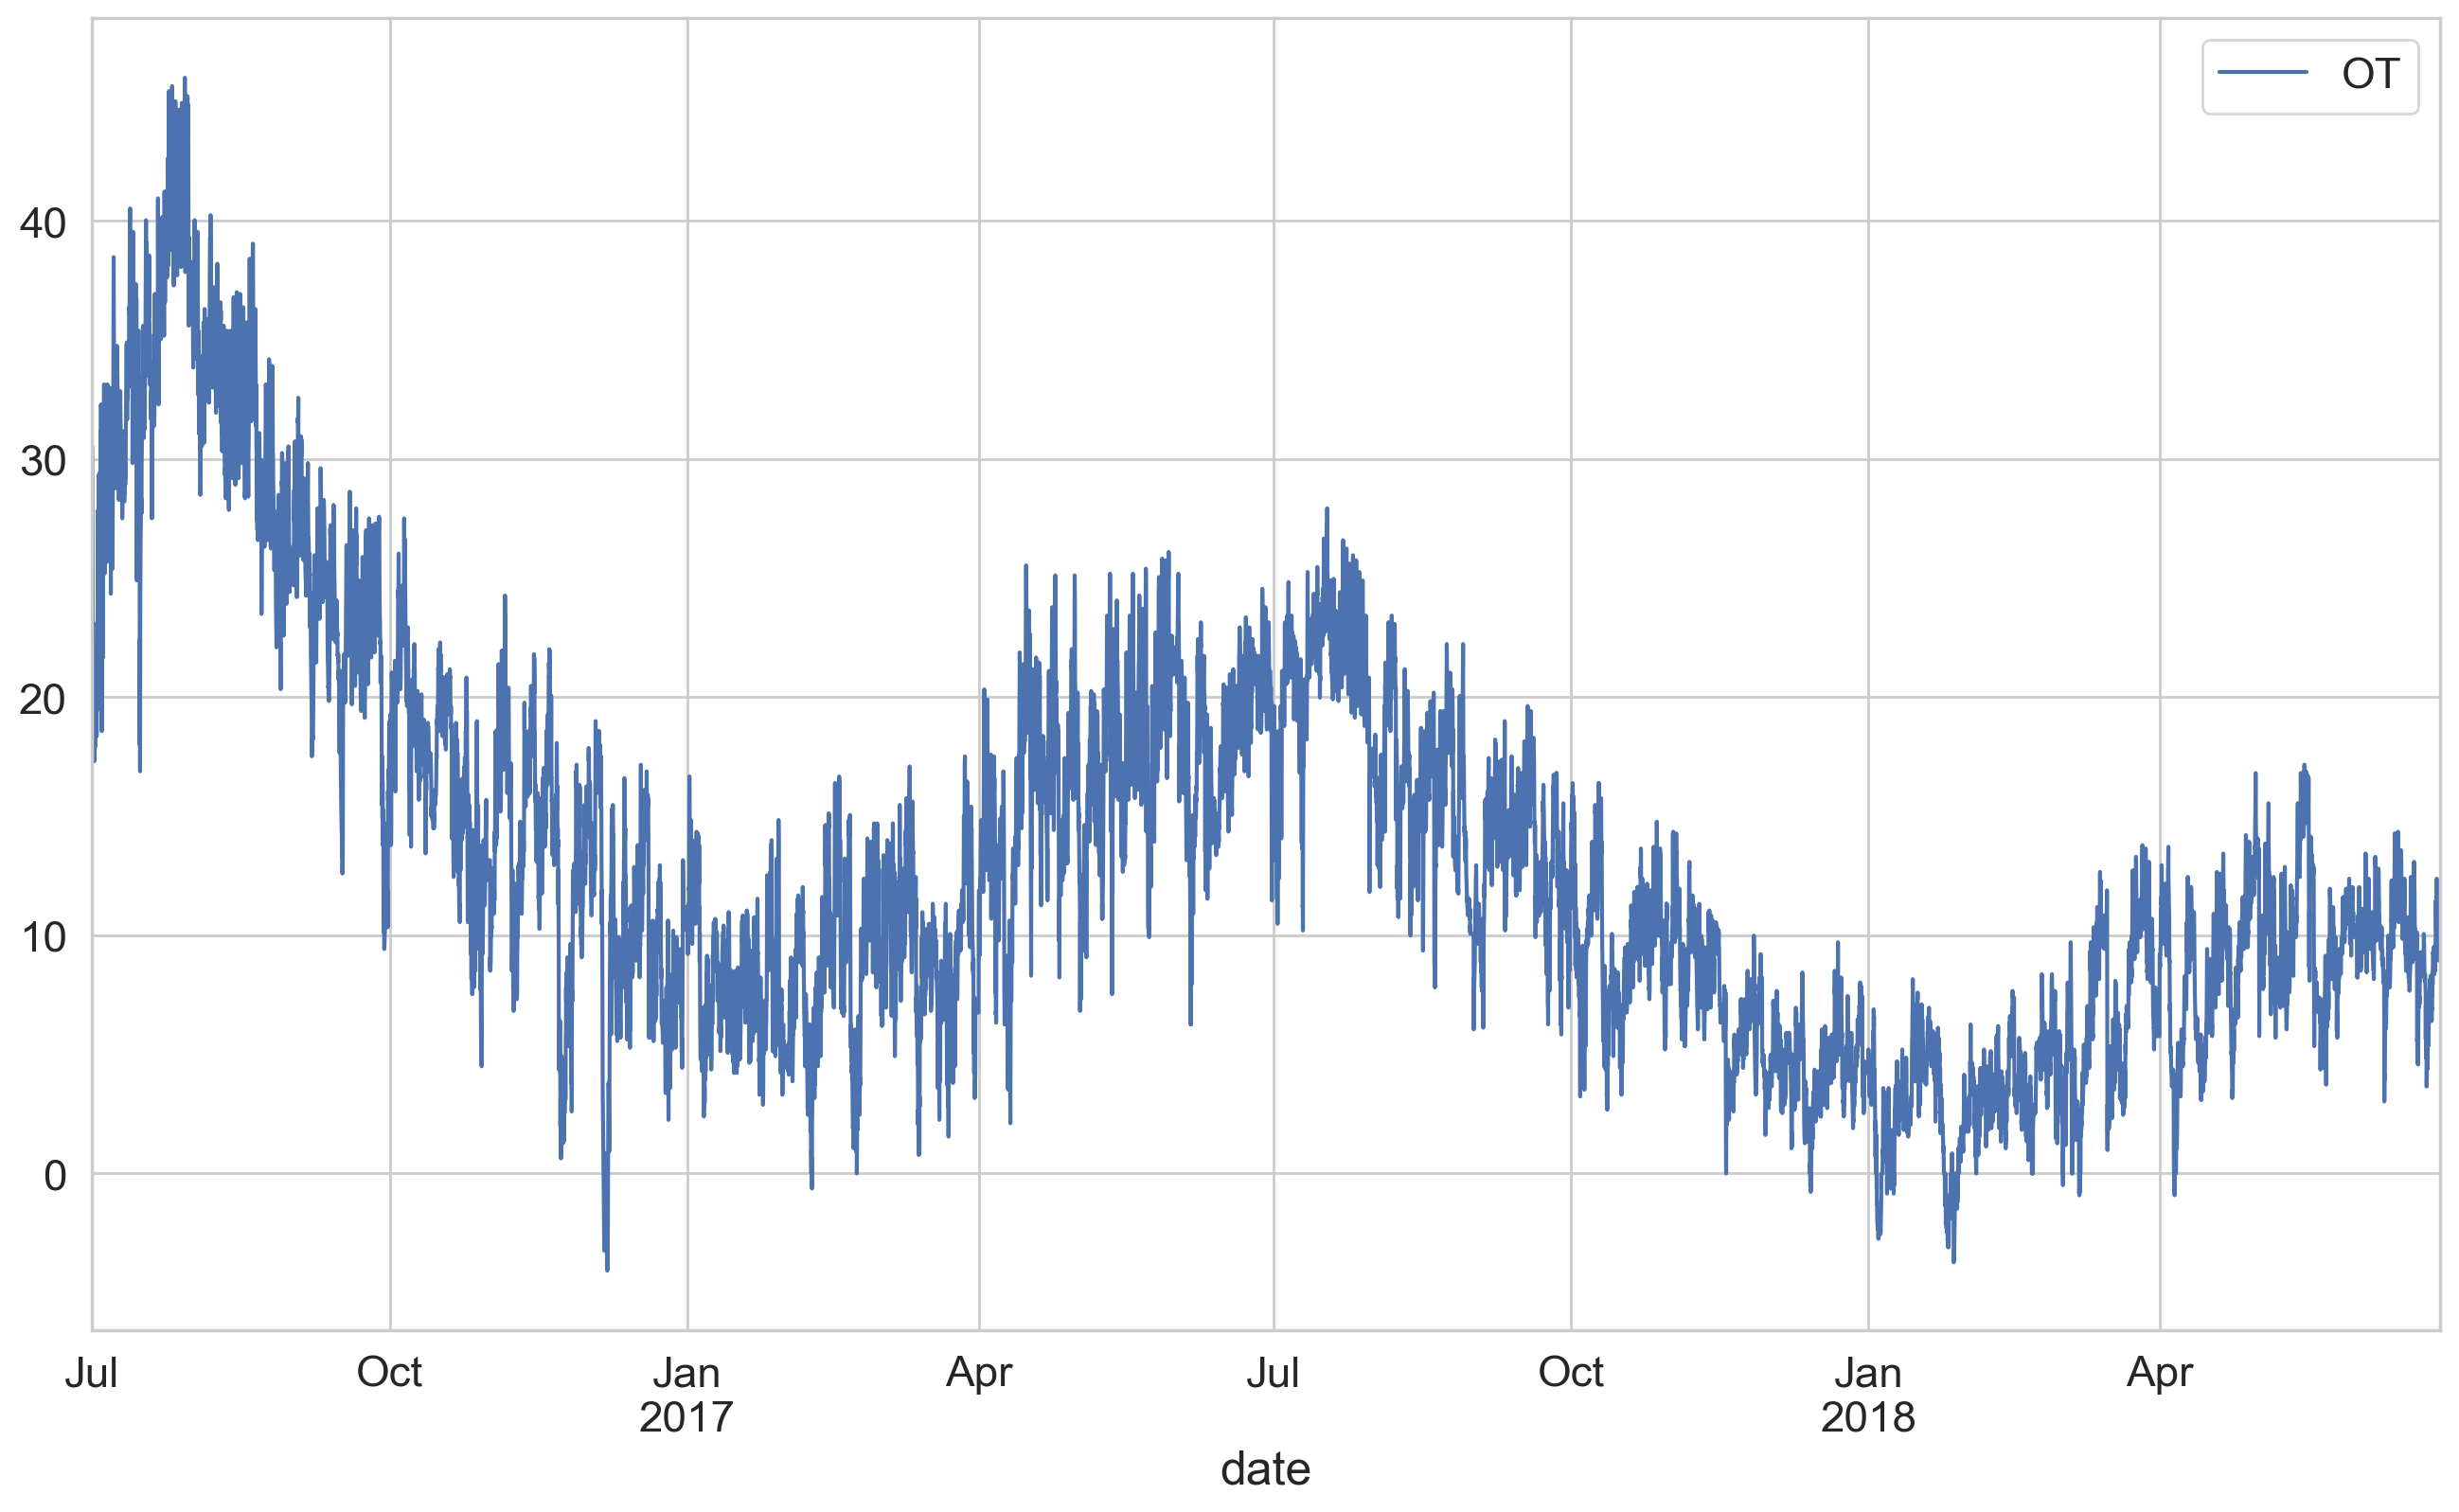

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
data_ticker.plot(x="date", y="OT", ax=ax)

## Создание признаков для ML-модели

Создадим dataframe с набором окон с помощью ```roll_time_series```, а затем с помощью него получим всевозможные статистические признаки с помощью ```extract_features```

In [10]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series, impute
from os.path import exists

if exists("features.parquet"):
    X = pd.read_parquet("features.parquet")
else:
    data_rolled = roll_time_series(
        data_ticker,
        column_id="id",
        column_sort="date",
        min_timeshift=1,
        max_timeshift=24,
    )

    X = extract_features(
        data_rolled.fillna(0),
        column_id="id",
        column_sort="date",
        column_value="OT",
        impute_function=impute,
        show_warnings=False
    )

    X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
    X.index.name = "last_date"

    X.to_parquet("features.parquet")

In [11]:
X.shape
X.head()

,OT__variance_larger_than_standard_deviation,OT__has_duplicate_max,OT__has_duplicate_min,OT__has_duplicate,OT__sum_values,OT__abs_energy,OT__mean_abs_change,OT__mean_change,OT__mean_second_derivative_central,OT__median,...,OT__fourier_entropy__bins_5,OT__fourier_entropy__bins_10,OT__fourier_entropy__bins_100,OT__permutation_entropy__dimension_3__tau_1,OT__permutation_entropy__dimension_4__tau_1,OT__permutation_entropy__dimension_5__tau_1,OT__permutation_entropy__dimension_6__tau_1,OT__permutation_entropy__dimension_7__tau_1,OT__query_similarity_count__query_None__threshold_0.0,OT__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 01:00:00,1.0,0.0,0.0,0.0,58.318001,1704.259375,2.743999,-2.743999,-1.544658e-16,29.159000,...,-0.000000,-0.000000,-0.000000,1.626909,2.397895,2.780466,2.926418,2.944439,0.0,13.174857
2016-07-01 02:00:00,1.0,0.0,1.0,1.0,86.105001,2476.376780,1.372000,-1.372000,1.372000e+00,27.787001,...,0.693147,0.693147,0.693147,-0.000000,2.397895,2.780466,2.926418,2.944439,0.0,13.174857
2016-07-01 03:00:00,1.0,0.0,0.0,1.0,111.149002,3103.578748,1.829000,-1.829000,2.498627e-04,27.787001,...,0.636514,0.636514,0.636514,0.693147,-0.000000,2.780466,2.926418,2.944439,0.0,13.174857
2016-07-01 04:00:00,1.0,0.0,0.0,1.0,133.097002,3585.293450,2.145750,-2.145750,-5.866687e-02,27.787001,...,0.636514,0.636514,1.098612,1.098612,0.693147,-0.000000,2.926418,2.944439,0.0,13.174857
2016-07-01 05:00:00,1.0,0.0,0.0,1.0,154.271002,4033.631717,1.871400,-1.871400,2.462499e-01,26.415501,...,0.562335,1.039721,1.386294,1.039721,1.098612,0.693147,-0.000000,2.944439,0.0,13.174857


## Формирование тренировочной и валидационной выборок

In [12]:
y = data_ticker.set_index("date").sort_index()["OT"].shift(-1).ffill()

In [13]:
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

In [14]:
split_date = pd.Timestamp("2018-01-01")
X_train, X_test = X.loc[X.index < split_date], X.loc[X.index >= split_date]
y_train, y_test = y.loc[y.index < split_date], y.loc[y.index >= split_date]

Продифференцируем таргет из train-выборки, чтобы предсказывать только изменение его значения, а не само значение

In [15]:
y_train = y_train.diff().bfill()

## PCA

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=75, random_state=42)
X_train_pca = pd.DataFrame(
    pca.fit_transform(X_train),
    index=X_train.index
)
X_test_pca = pd.DataFrame(
    pca.transform(X_test),
    index=X_test.index
)

## Нормализация признаков

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_pca_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_pca),
    index=X_train_pca.index,
    columns=X_train_pca.columns
)
X_test_pca_scaled = pd.DataFrame(
    scaler.transform(X_test_pca),
    index=X_test_pca.index,
    columns=X_test_pca.columns
)

In [18]:
X_train_pca_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
2016-07-01 01:00:00,0.013652,1.115263,-0.087939,-0.614397,-0.533007,-2.470887,-0.638060,-0.149203,0.070010,-0.124452,...,-0.053383,3.104901,1.193590,0.493568,-1.654805,5.028600,7.464006,2.378292,-11.592113,-3.711204
2016-07-01 02:00:00,0.013652,20.029140,-23.283105,-28.320596,-22.570577,16.465885,-0.008368,-30.488900,-7.026120,9.292631,...,-0.025893,0.470170,0.642843,0.137850,-0.831242,1.970462,2.104007,0.483075,-2.517295,-1.622709
2016-07-01 03:00:00,0.013652,18.212031,-20.962378,-25.687615,-20.380338,14.295241,-0.051880,-28.189184,-6.509498,8.709972,...,0.220304,1.484044,1.534780,0.332797,-0.672158,2.191514,2.912159,0.609033,-1.881527,-1.400574
2016-07-01 04:00:00,0.013652,23.479368,-24.256444,-29.261382,-24.457869,20.623484,0.378032,35.432264,1.691862,-4.779057,...,0.616129,-1.339918,0.467616,-0.108546,-1.829488,2.965864,3.653365,-0.816966,-3.700293,0.026283
2016-07-01 05:00:00,0.013652,20.644692,-21.366512,-25.769216,-21.505083,17.617577,0.282959,30.457448,1.952310,-4.280679,...,1.087955,2.522087,2.355452,0.690980,-2.276859,2.290415,4.244520,-0.071981,-3.176504,0.268928


## Обучение классических ML-моделей

In [19]:
from sklearn.metrics import mean_squared_error

In [69]:
from catboost import CatBoostRegressor

cat_boost_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=5,
    min_data_in_leaf=20,
    bagging_temperature=1,
    loss_function="RMSE",
    random_strength=3,
    random_seed=42,
    verbose=False
)

cat_boost_model.fit(X_train_pca_scaled, y_train)
cat_boost_pred = y_test.shift(1).bfill() + cat_boost_model.predict(X_test_pca_scaled)
cat_boost_mse = mean_squared_error(y_test, cat_boost_pred)

In [80]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=32,
    max_depth=-1,
    min_child_samples=64,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.75,
    reg_alpha=0.5,
    reg_lambda=2,
    objective="regression",
    metric="rmse",
    random_state=42
)

lgb_model.fit(X_train_pca_scaled, y_train)
lgb_pred = y_test.shift(1).bfill() + lgb_model.predict(X_test_pca_scaled)
lgb_mse = mean_squared_error(y_test, lgb_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 13175, number of used features: 75
[LightGBM] [Info] Start training from score -0.001922


In [48]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=3,
    colsample_bytree=0.8,
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=1,
    min_child_weight=3,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42
)

xgb.fit(X_train_pca_scaled, y_train)
xgb_pred = y_test.shift(1).bfill() + xgb.predict(X_test_pca_scaled)
xgb_mse = mean_squared_error(y_test, xgb_pred)

## Сравнение MSE baseline'ов и ML-моделей

Здесь приведены 3 baseline'а, значения метрики MSE которых желательно превзойти:
1. Наивное предсказание по предыдущему значению
2. Взятие среднего от валидационной выборки
3. Скользящее окно размера 3

In [87]:
naive_pred = y_test.shift(1).fillna(0)
mean_pred = np.ones_like(y_test) * y_test.mean()
rolling_window_pred = y_test.shift(1).rolling(window=3, min_periods=1).mean().bfill().ffill()

naive_mse = mean_squared_error(y_test, naive_pred)
mean_mse = mean_squared_error(y_test, mean_pred)
rolling_window_mse = mean_squared_error(y_test, rolling_window_pred)

print(f"Naive MSE: {naive_mse:.4f}")
print(f"Mean MSE: {mean_mse:.4f}")
print(f"Rolling Window(3) MSE: {rolling_window_mse:.4f}")

Naive MSE: 0.4183
Mean MSE: 15.0707
Rolling Window(3) MSE: 0.6401


И значения метрики MSE для каждой модели:

In [86]:
print(f"CatBoost MSE: {cat_boost_mse:.4f}")
print(f"LightGBM MSE: {lgb_mse:.4f}")
print(f"XGBRegressor MSE: {xgb_mse:.4f}")

CatBoost MSE: 0.3967
LightGBM MSE: 0.4099
XGBRegressor MSE: 0.3981


- Модель ```CatBoostRegressor``` показала лучший результат среди трёх ML-моделей, поэтому будет использована далее в построении графиков в сравнении с baseline'ами
- Её предсказания лучше наивного предсказания (самый лучший по MSE baseline) на **~ 5.5%**

## Сравнение предсказаний выбранной ML-модели и baseline'ов на графиках

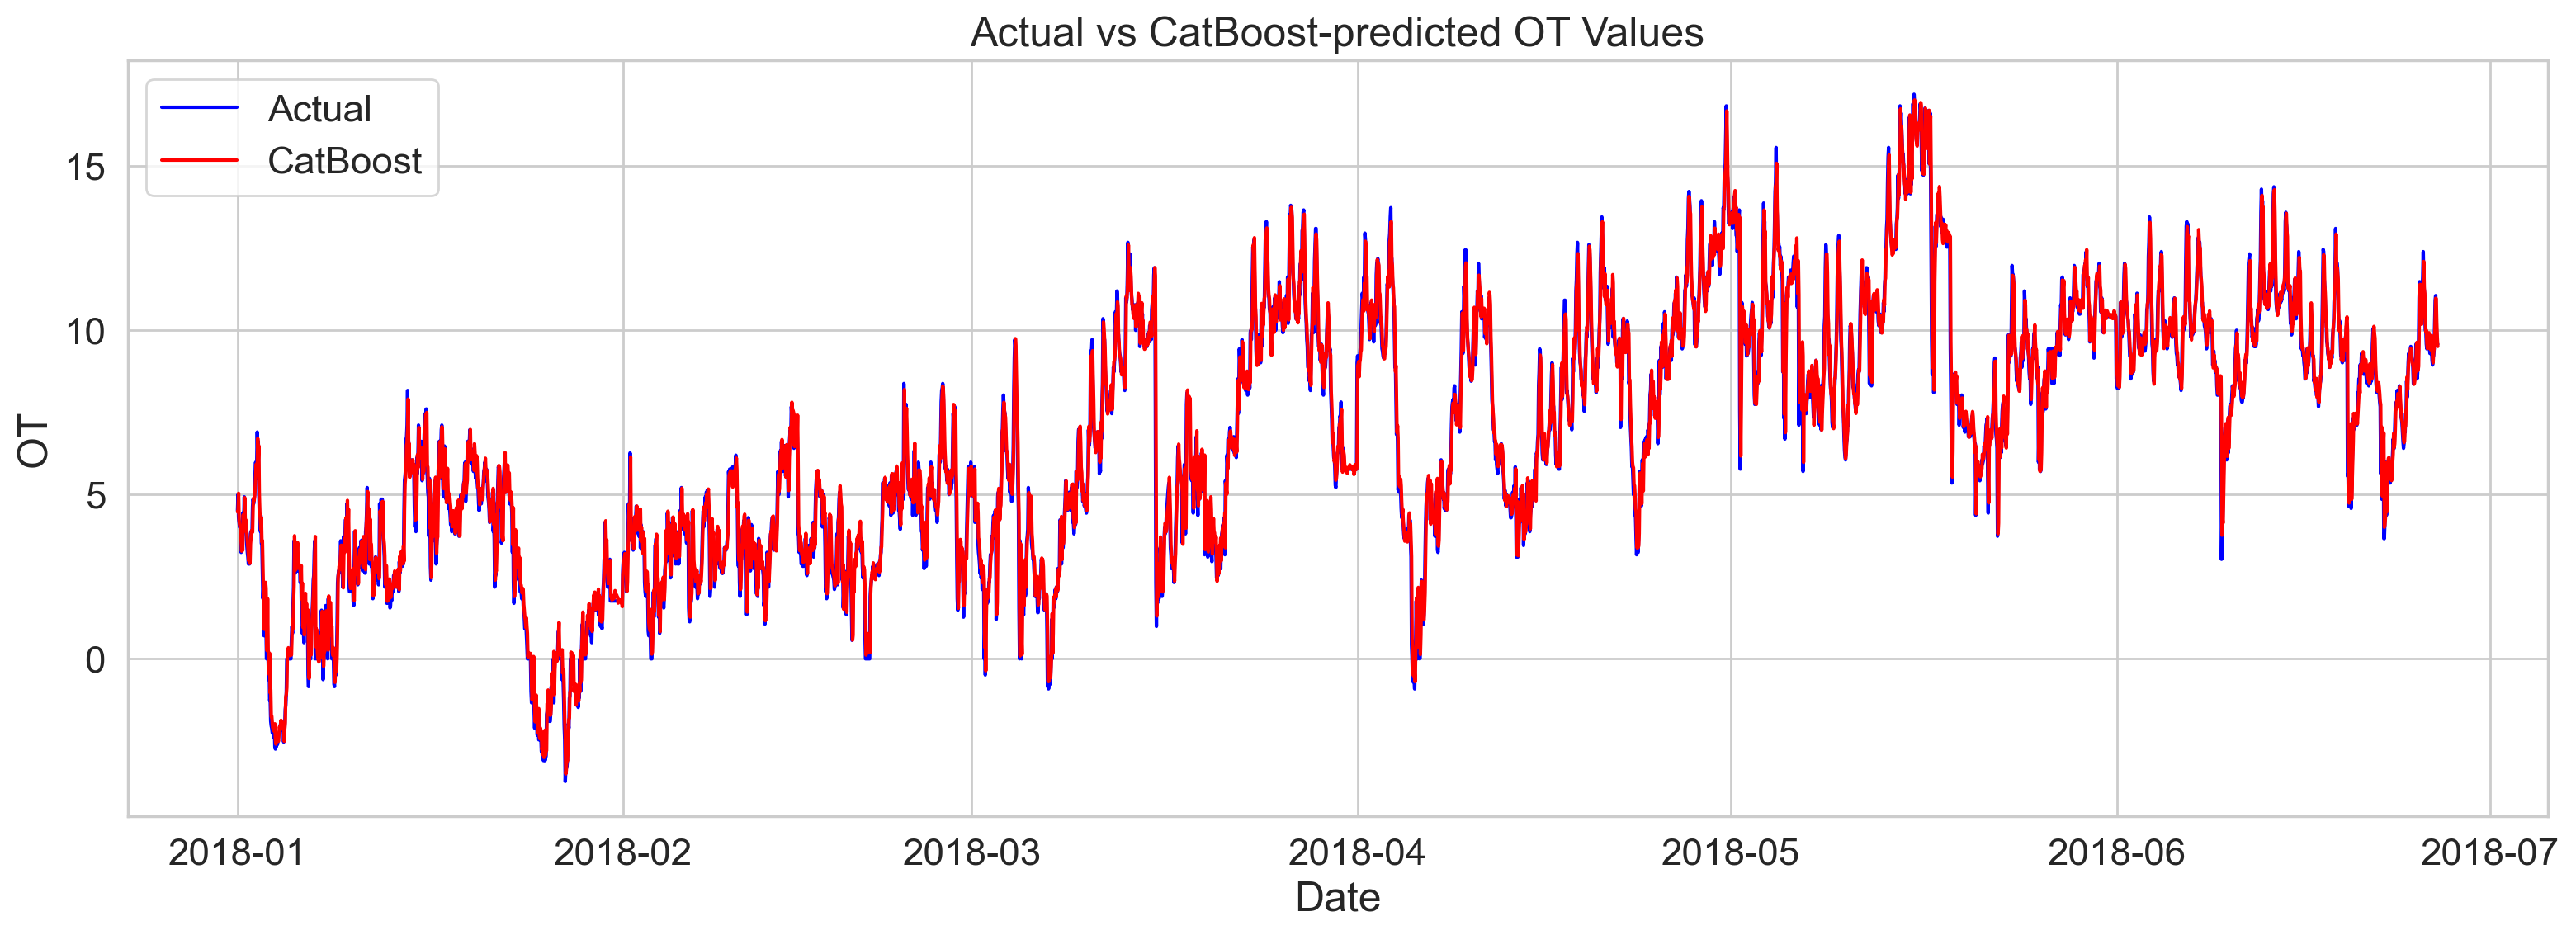

In [91]:
plt.figure(figsize=(16, 6))
plt.plot(y_test.index, y_test.values, label="Actual", color="blue")
plt.plot(y_test.index, cat_boost_pred, label="CatBoost", color="red")

plt.title('Actual vs CatBoost-predicted OT Values')
plt.xlabel('Date')
plt.ylabel('OT')

plt.legend()
plt.tight_layout()
plt.show()

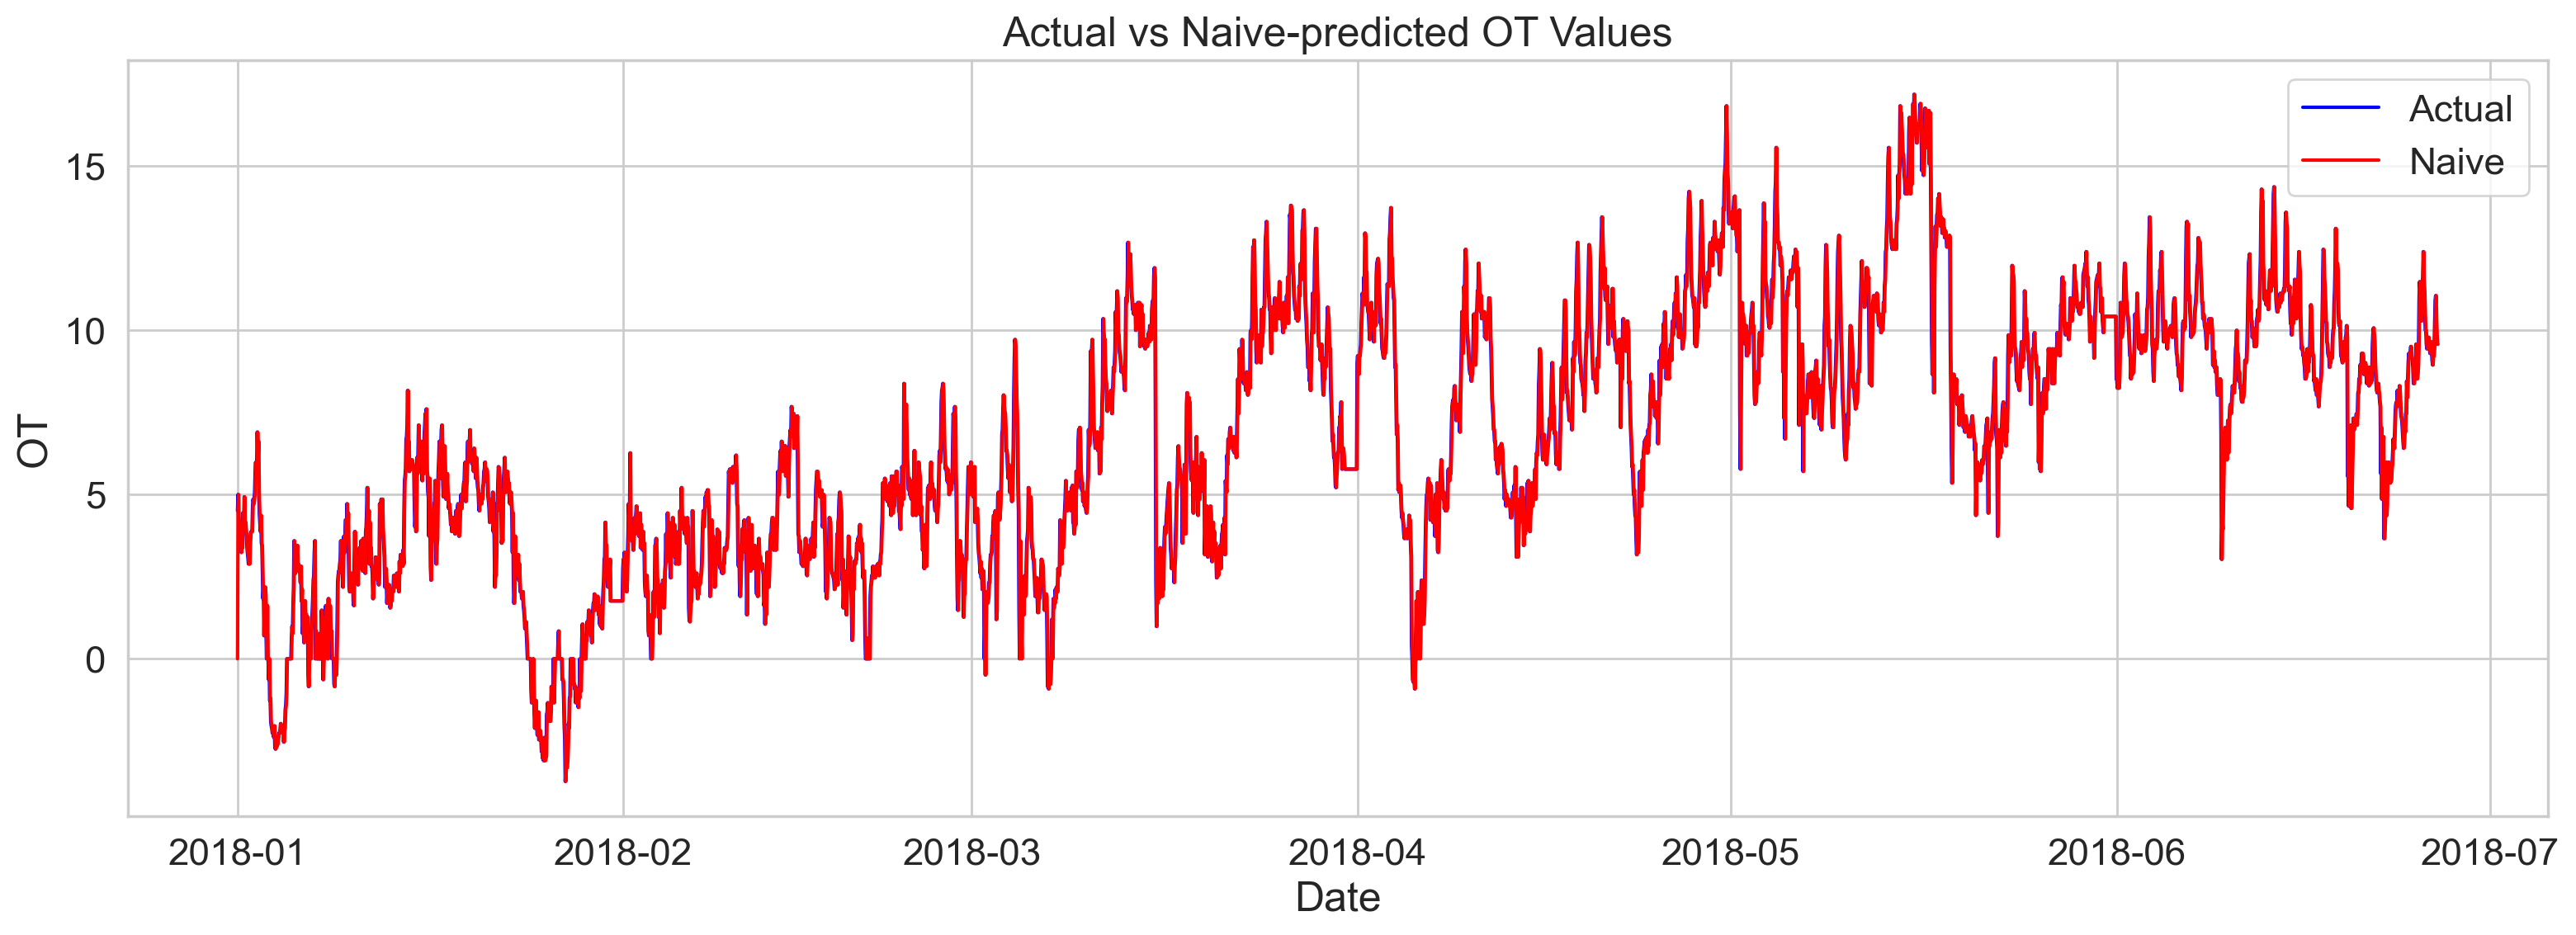

In [92]:
plt.figure(figsize=(16, 6))
plt.plot(y_test.index, y_test.values, label="Actual", color="blue")
plt.plot(y_test.index, naive_pred, label="Naive", color="red")

plt.title('Actual vs Naive-predicted OT Values')
plt.xlabel('Date')
plt.ylabel('OT')

plt.legend()
plt.tight_layout()
plt.show()

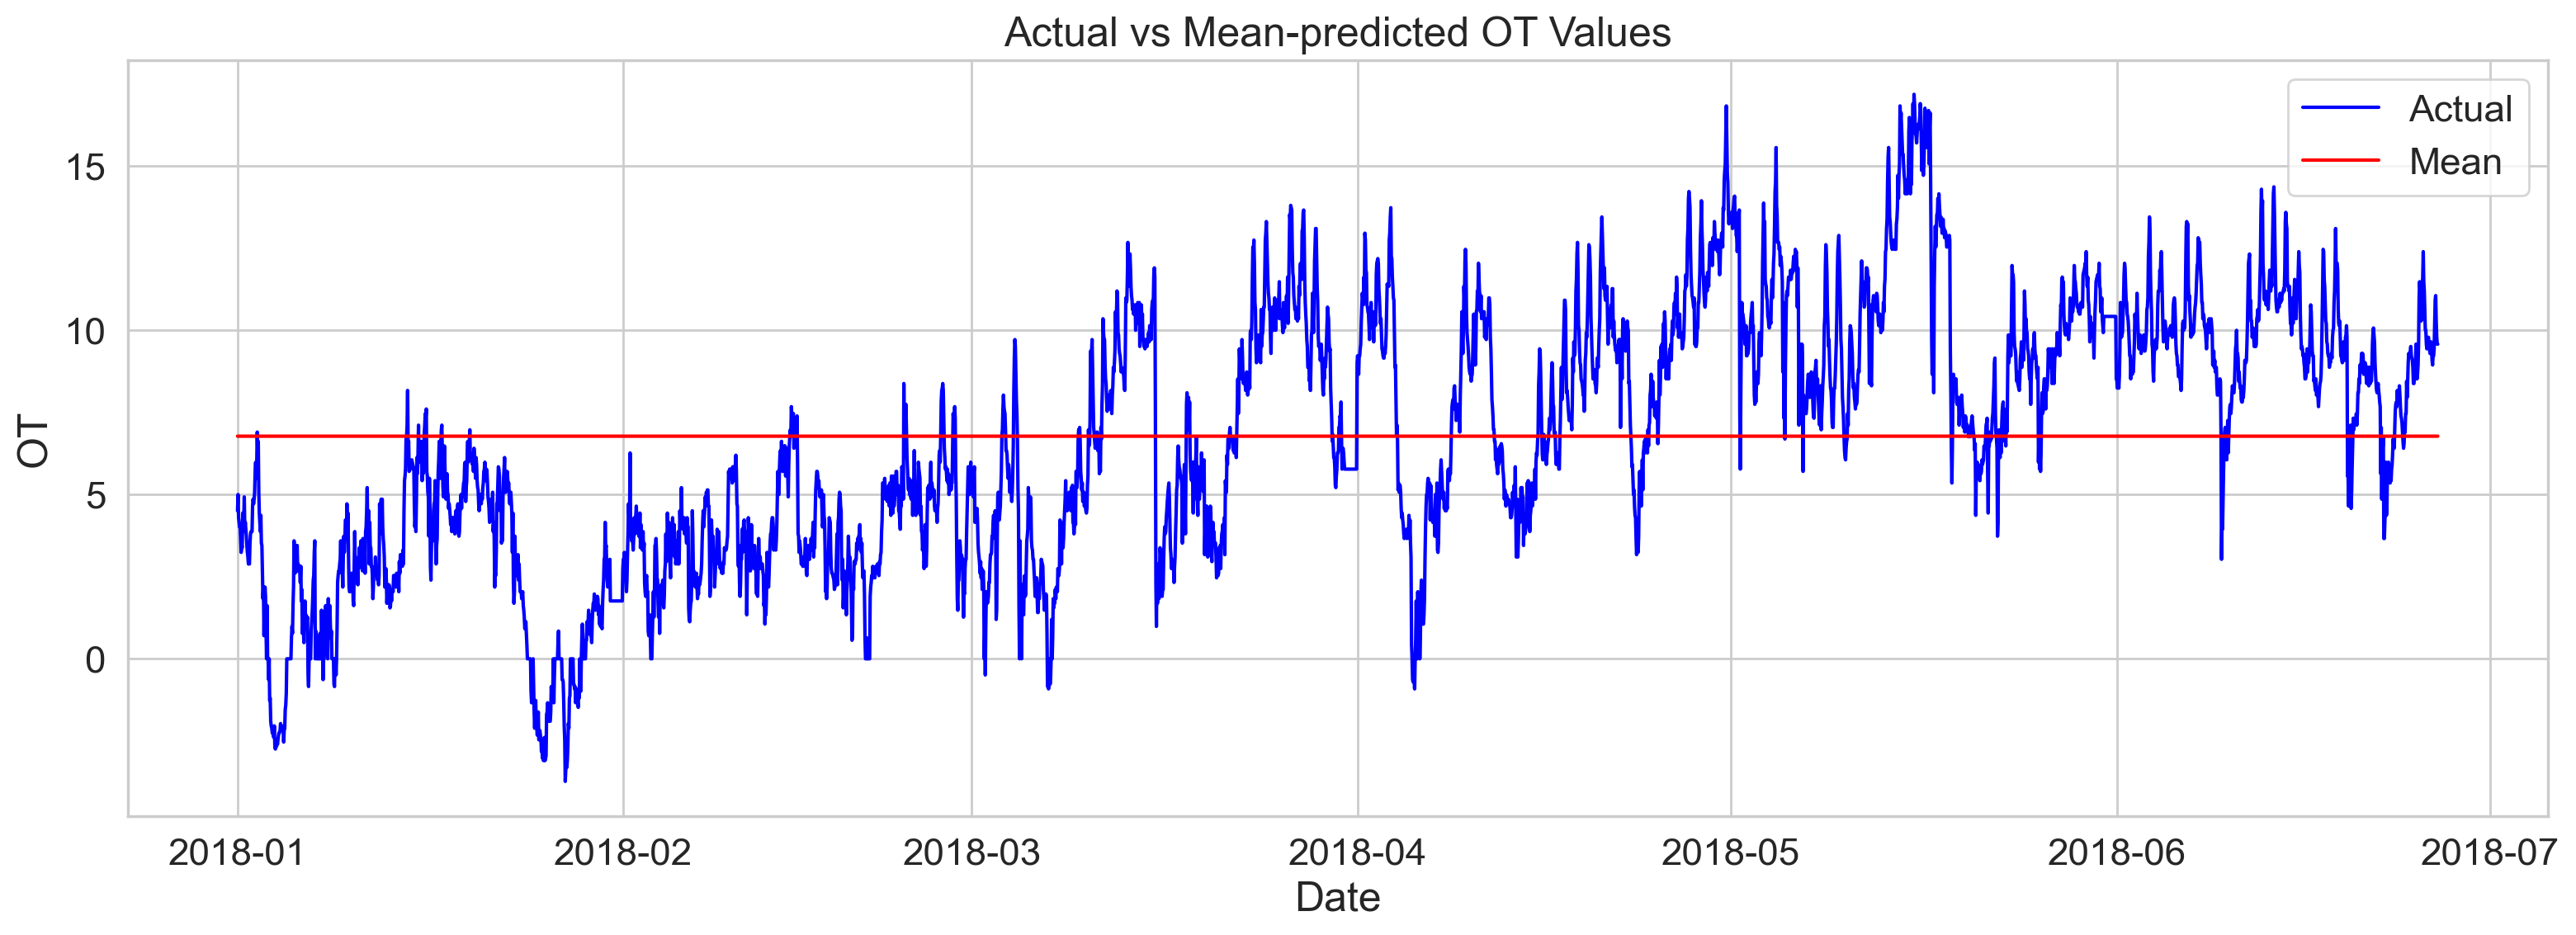

In [93]:
plt.figure(figsize=(16, 6))
plt.plot(y_test.index, y_test.values, label="Actual", color="blue")
plt.plot(y_test.index, mean_pred, label="Mean", color="red")

plt.title('Actual vs Mean-predicted OT Values')
plt.xlabel('Date')
plt.ylabel('OT')

plt.legend()
plt.tight_layout()
plt.show()

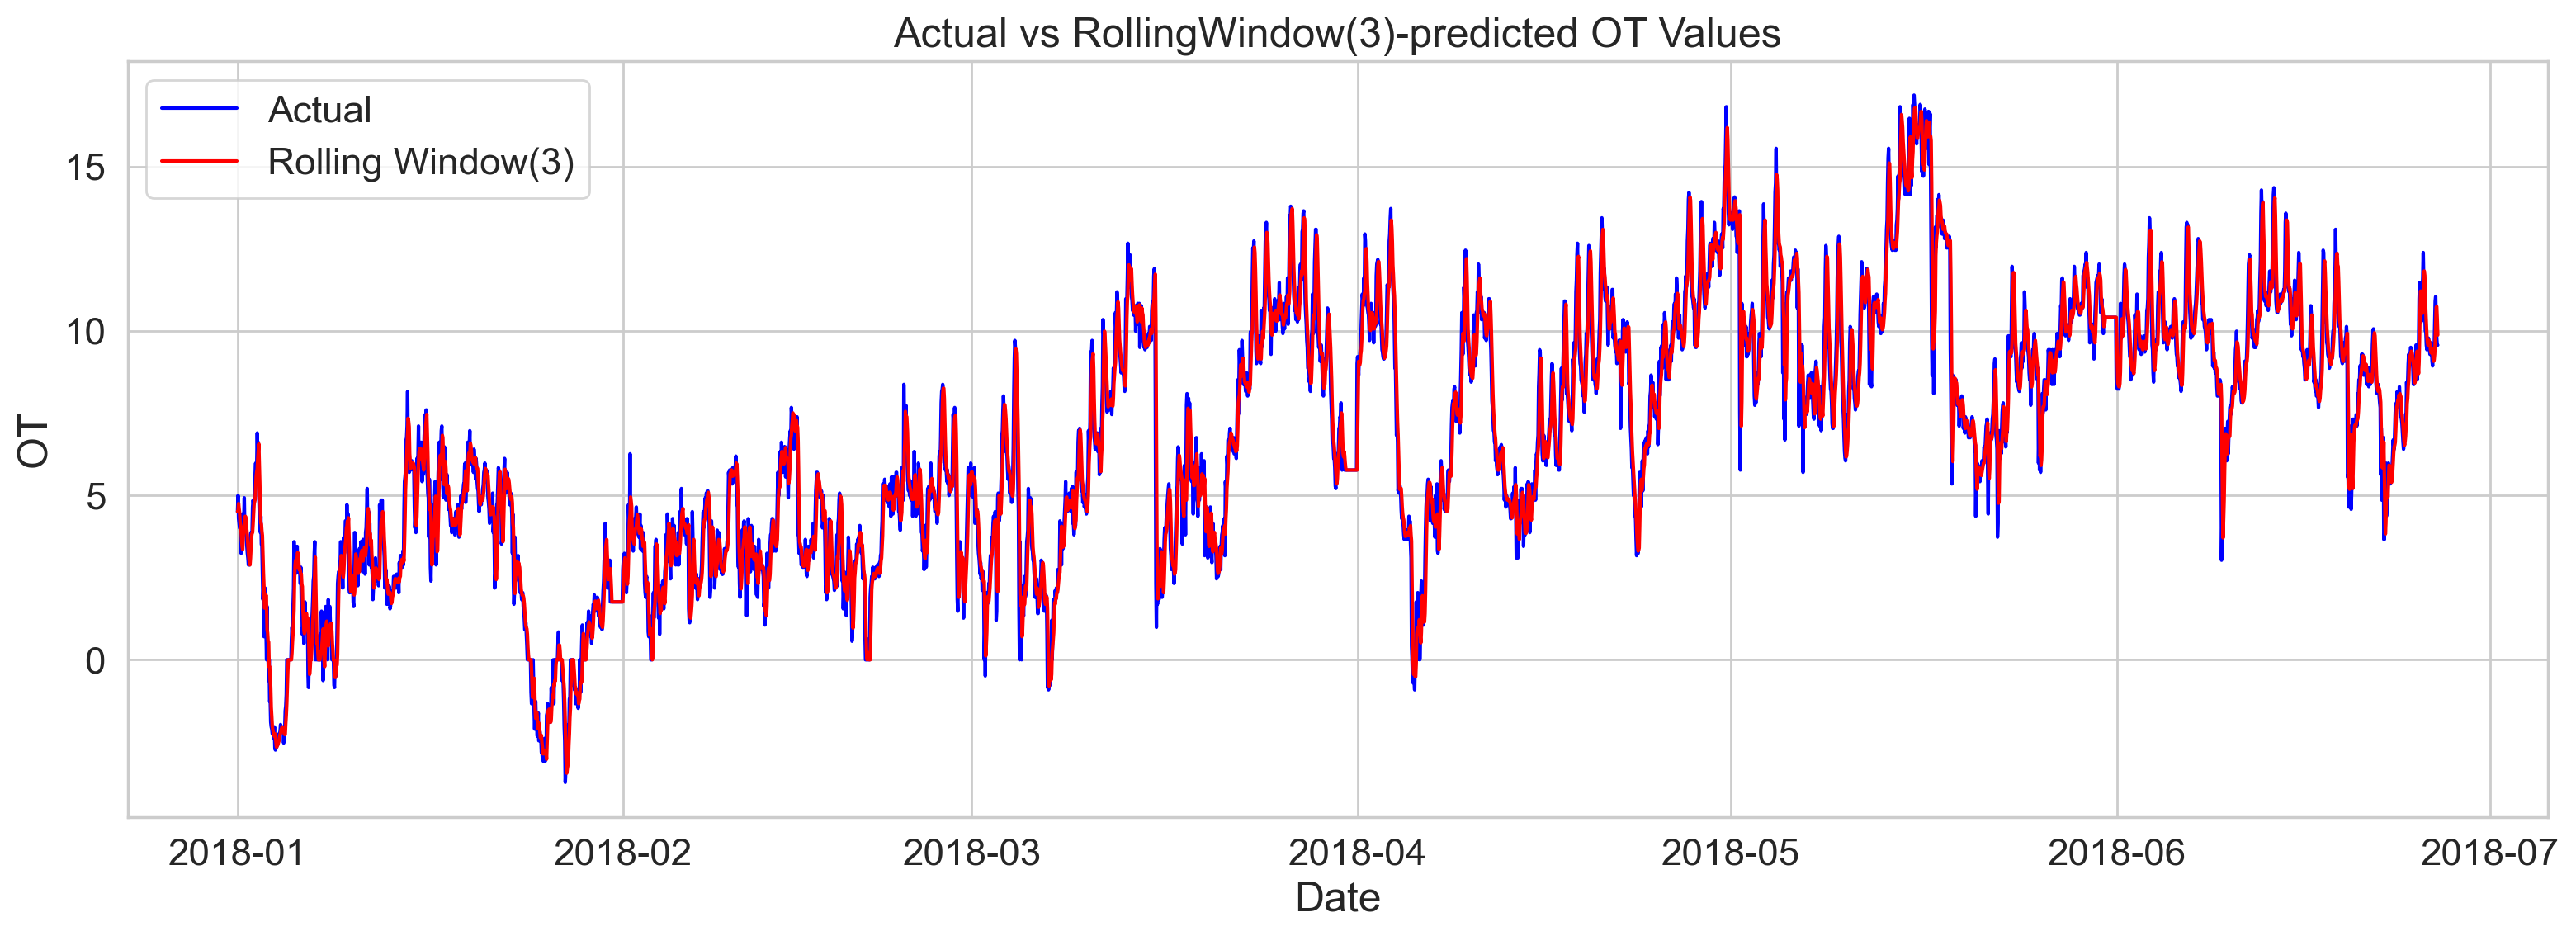

In [94]:
plt.figure(figsize=(16, 6))
plt.plot(y_test.index, y_test.values, label="Actual", color="blue")
plt.plot(y_test.index, rolling_window_pred, label="Rolling Window(3)", color="red")

plt.title('Actual vs RollingWindow(3)-predicted OT Values')
plt.xlabel('Date')
plt.ylabel('OT')

plt.legend()
plt.tight_layout()
plt.show()